In [1]:
# Advance Lane Finding

In [2]:
#1.-Camera Calibartion

In [3]:
from moviepy.editor import VideoFileClip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import os
%matplotlib inline

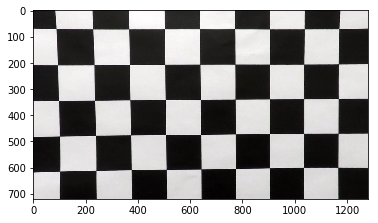

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')
object_points = [] #real points 3D
image_points = [] #point of the different images 2D

obj_points = np.zeros((6*9,3), np.float32)
obj_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
total = 0
for image in images:
    
    #read each image
    img = mpimg.imread(image) 

    #convert to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    #find corner for the cheesboard
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        image_points.append(corners)
        object_points.append(obj_points)

#calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)

#test the calibration a plot image1
test_image = mpimg.imread('camera_cal/calibration1.jpg') 
dst = cv2.undistort(test_image, mtx, dist, None, mtx)
plt.imshow(dst)



In [5]:
test_image = mpimg.imread('test_images/straight_lines1.jpg') 
dst = cv2.undistort(test_image, mtx, dist, None, mtx)


In [6]:
#2.- COLOR TRANSFORM, GRADIENTS FOR BINARY IMAGE

In [7]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def get_binary_filtered_img(path,mtx, dist, saturation_thresh=(170, 255), sobel_thresh=(20, 100), light_thresh=(0,80)):
    
    #reading in an image
    if type(path) == type("String"):
        img = mpimg.imread(path)
    else:
        img = path
    
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    # Apply the following steps to img
    # Convert to hls color space
    hls = cv2.cvtColor(undist_image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    
    #calculating sobel for X
    sobel_x = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    # Take the absolute value of the derivative or gradient
    abs_sobel_x = np.absolute(sobel_x)
    
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Threshold color channel
    saturation_binary = np.zeros_like(s_channel)
    saturation_binary[(s_channel >= saturation_thresh[0]) & (s_channel <= saturation_thresh[1])] = 1
    
    light_binary = np.zeros_like(l_channel)
    light_binary[(l_channel >= light_thresh[0]) & (l_channel <= light_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sobel_binary), sobel_binary, sobel_binary)) * 255
    combined_binary_1 = np.zeros_like(sobel_binary)
    combined_binary_1[(saturation_binary == 1) | (sobel_binary == 1)] = 1
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[((saturation_binary == 1) | (sobel_binary == 1)) & (light_binary == 1)] = 1
    # 6) Return this mask as your binary_output image
    '''fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(2, 2, 1)
    plt.imshow(img)
    fig.add_subplot(2, 2, 2)
    plt.imshow(combined_binary_1, cmap= 'gray')
    fig.add_subplot(2, 2, 3)
    plt.imshow(combined_binary, cmap= 'gray')
    fig.add_subplot(2, 2, 4)
    plt.imshow((combined_binary - combined_binary_1), cmap= 'gray')'''
    
    
    return combined_binary, undist_image

binary_images = {}
undistorted_images = {}

list_images = os.listdir("test_images/")
for file in list_images:
    path_image = "test_images/"+file
    f_binary_image, undist_image  = get_binary_filtered_img(path_image, mtx, dist, saturation_thresh=(180, 255), sobel_thresh=(20, 80), light_thresh=(50,255))
    binary_images["binary_"+file] = f_binary_image
    undistorted_images ["undist_"+file] = undist_image
    

#plt.imshow(grad_binary, cmap='gray')

In [8]:
#3.-PERSPECTIVE TRANSFORM

In [9]:
def prespective_transform(img, source_point, destination_point):
    
    #transforming binary image to 3d image for drawing color lines
    img_with_lines_s = np.dstack(( img, img, img))* 255
    
    #parameters for color lines
    color=[255, 0, 0]
    thickness=4
    
    
    #Drawings color lines for source
    cv2.line(img_with_lines_s, (source_point[0,0], source_point[0,1]), (source_point[1,0], source_point[1,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[1,0], source_point[1,1]), (source_point[2,0], source_point[2,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[2,0], source_point[2,1]), (source_point[3,0], source_point[3,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[3,0], source_point[3,1]), (source_point[0,0], source_point[0,1]), color, thickness)
    
    
    img_size = (img.shape[1],img.shape[0])
    Warped_matrix = cv2.getPerspectiveTransform(source_point,destination_point)
    image_warpe = cv2.warpPerspective(img, Warped_matrix, img_size)
    
    #transforming binary image to 3d image for drawing color lines
    image_warpe_with_lines = np.dstack(( image_warpe, image_warpe, image_warpe))* 255
    
    #Drawings color lines for destination
    cv2.line(image_warpe_with_lines, (destination_point[0,0], destination_point[0,1]), (destination_point[1,0], destination_point[1,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[1,0], destination_point[1,1]), (destination_point[2,0], destination_point[2,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[2,0], destination_point[2,1]), (destination_point[3,0], destination_point[3,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[3,0], destination_point[3,1]), (destination_point[0,0], destination_point[0,1]), color, thickness)
    
    #print figures
    '''fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img_with_lines_s, cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(image_warpe_with_lines, cmap='gray')'''
    #plt.show()
    
    return image_warpe

#Source points
x1_s = 200
x2_s = 555
x3_s = 732
x4_s = 1100
y_top_s = 720
y_low_s = 480
#generating the array for source points
src = np.float32([[x1_s, y_top_s],[x2_s, y_low_s],[x3_s, y_low_s],[x4_s, y_top_s]])

#destination points
x_low_d = 290
x_top_d = 990
y_top_d = 720
y_low_d = 0
#generating the array for destination points
dst = np.float32([[x_low_d, y_top_d],[x_low_d, y_low_d],[x_top_d, y_low_d],[x_top_d, y_top_d]])

prespective_images = {}
fig = plt.figure(figsize=(100, 100))
for key, image in binary_images.items() :
    print (key)
    f_prespective_image = prespective_transform(image,src,dst)
    prespective_images["presp_"+key] = f_prespective_image
    

binary_straight_lines1.jpg
binary_straight_lines2.jpg
binary_test1.jpg
binary_test2.jpg
binary_test3.jpg
binary_test4.jpg
binary_test5.jpg
binary_test6.jpg


<Figure size 7200x7200 with 0 Axes>

In [10]:
#4.- SLIDING WINDOW DRAWING RECTANGLES

presp_binary_straight_lines1.jpg
presp_binary_straight_lines2.jpg
presp_binary_test1.jpg
presp_binary_test2.jpg
presp_binary_test3.jpg
presp_binary_test4.jpg
presp_binary_test5.jpg
presp_binary_test6.jpg


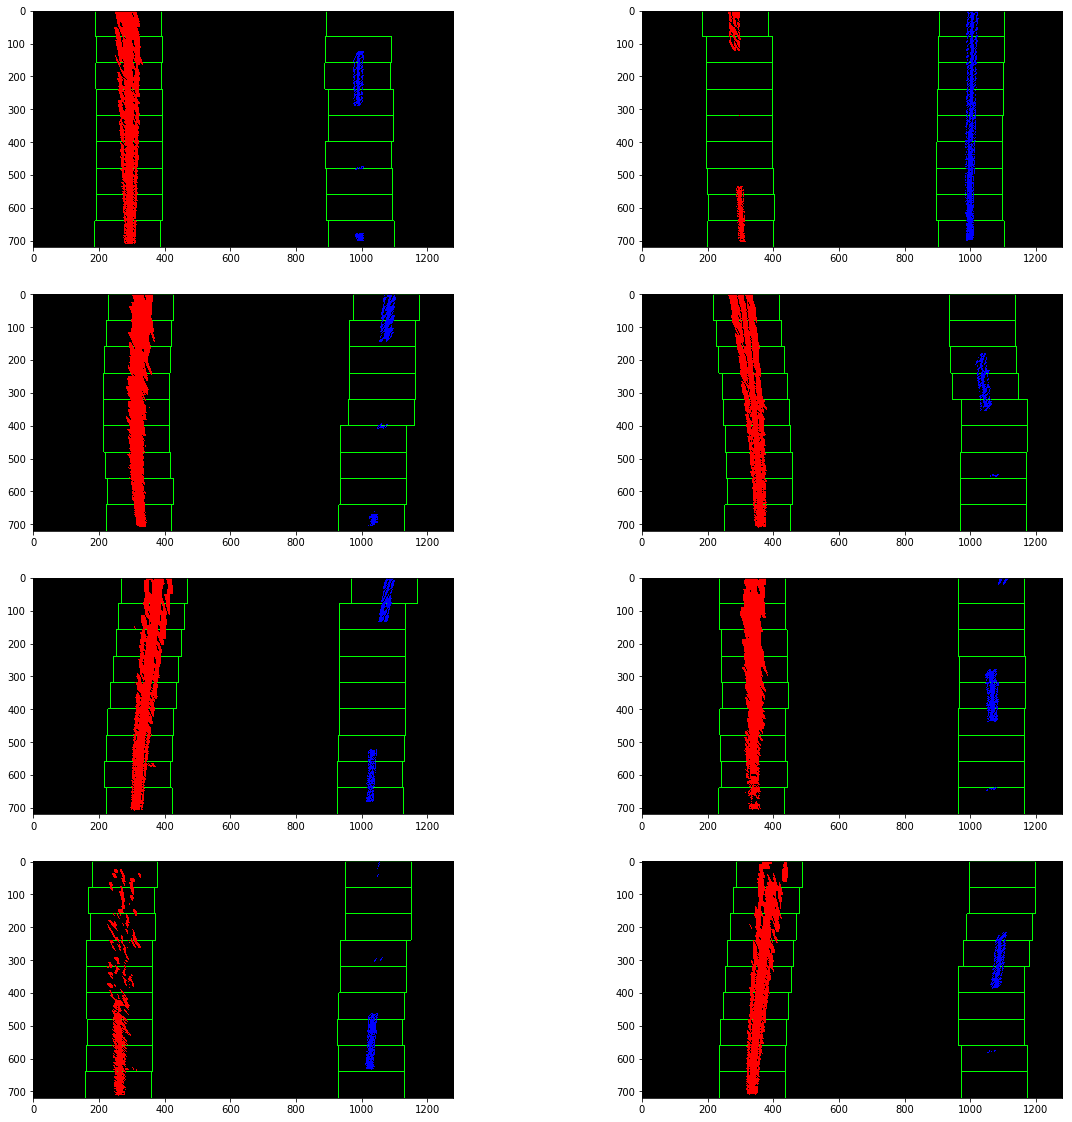

In [11]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &( nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    #Fit a second order polynomial to each using `np.polyfit` ###
    try:
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)
    except TypeError:
        left_fit = np.array([0,0,0])
        right_fit = np.array([0,0,0])
        pass


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return binary_warped, out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

poly_fit_images = {}
fig = plt.figure(figsize=(20, 20))
count = 1
for key, image in prespective_images.items() :
    print (key)
    fig.add_subplot(4, 2, count)
    poly_fit_images[key] = fit_polynomial(image)
    plt.imshow(poly_fit_images[key][1])
    count += 1

    

In [12]:
#5.- SEARCH FROM PREVIOUS POLYFIT RESULT AND CURVATURE CALCULATION

presp_binary_straight_lines1.jpg
presp_binary_straight_lines2.jpg
presp_binary_test1.jpg
presp_binary_test2.jpg
presp_binary_test3.jpg
presp_binary_test4.jpg
presp_binary_test5.jpg
presp_binary_test6.jpg


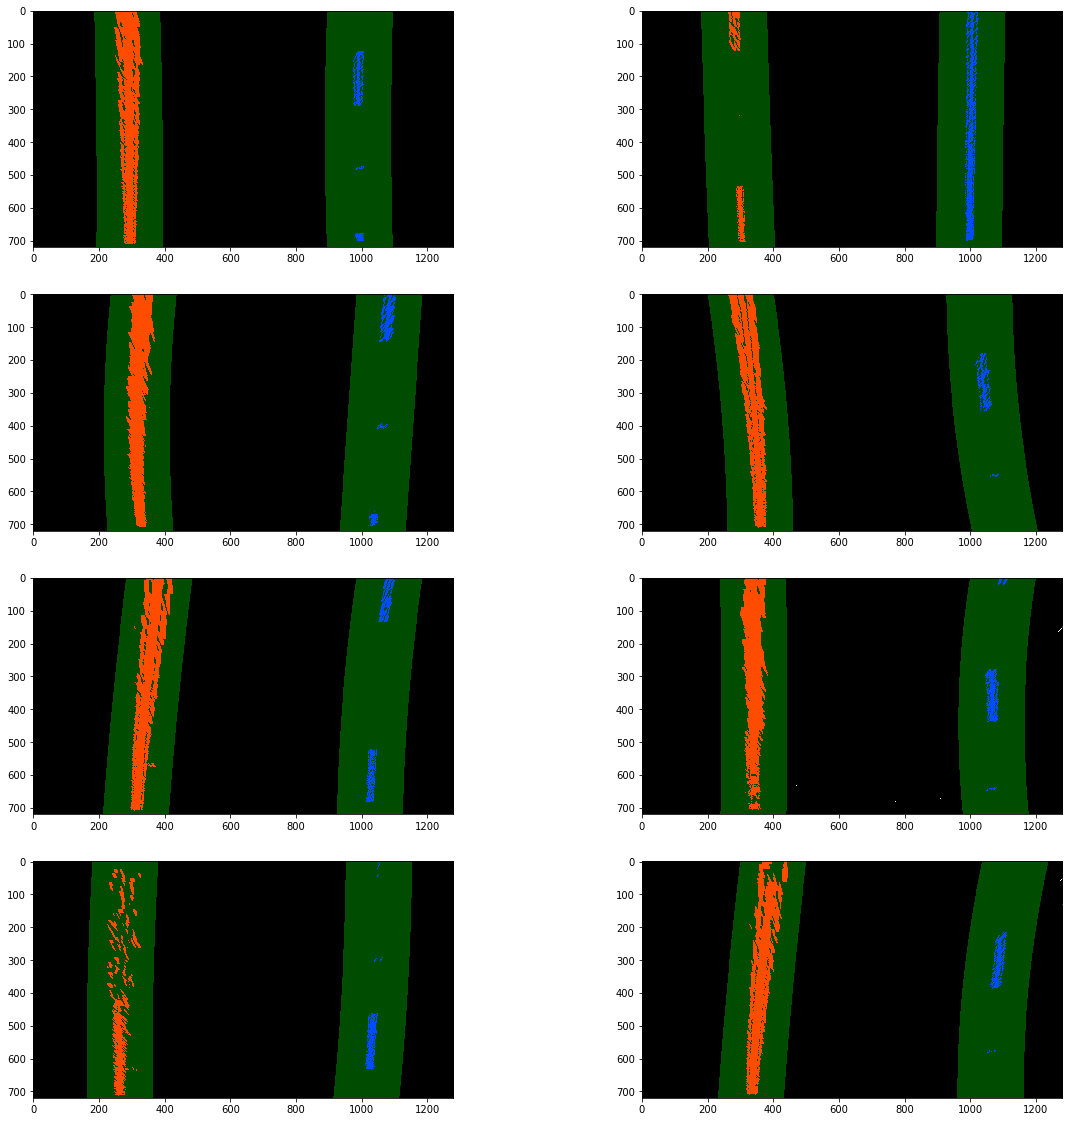

In [13]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    try:
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)
    except TypeError:
        left_fit = np.array([0,0,0])
        right_fit = np.array([0,0,0])
        pass
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Calculation the Curvature
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    try:
        left_fit_m = np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
        right_fit_m = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)
    except TypeError:
        left_fit_m = np.array([0,0,0])
        right_fit_m = np.array([0,0,0])
        pass
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image in m
    y_eval_m = y_eval * ym_per_pix
    
    ##### Implement the calculation of R_curve (radius of curvature) from f(y) = Ay^2 + By + C  f'(y) = 2Ay + B  f''(y) = 2A#####
    #Rcurve = ([1+ (dx/dy)^2]^(3/2))/(|(d2x/dy2)|) = ([1+ (2Ay + B)^2]^(3/2))/(|2A|)
    left_curve_rad = np.power((1+np.power(2*left_fit[0]*y_eval+left_fit[1],2)),(3/2))/np.absolute(2*left_fit[0]) 
    right_curve_rad = np.power((1+np.power(2*right_fit[0]*y_eval+right_fit[1],2)),(3/2))/np.absolute(2*right_fit[0])   
    #print(left_curve_rad, right_curve_rad)
    
    ### Real world calculation
    left_curve_rad_m = np.power((1+np.power(2*left_fit_m[0]*y_eval_m*+left_fit_m[1],2)),(3/2))/np.absolute(2*left_fit_m[0])  
    right_curve_rad_m = np.power((1+np.power(2*right_fit_m[0]*y_eval_m+right_fit_m[1],2)),(3/2))/np.absolute(2*right_fit_m[0])   
    #print(left_curve_rad_m, 'm', right_curve_rad_m, 'm')
    
    
    
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    return left_fitx, right_fitx, ploty, left_curve_rad_m, right_curve_rad_m

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Set the area of search based on activated x-values ###

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_curve_rad_m, right_curve_rad_m = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty, left_curve_rad_m, right_curve_rad_m

#DU -Don't use it
search_around_poly_out = {}
fig = plt.figure(figsize=(20, 20))
count = 1
#poly_fit_images_items tuple contains binary_warped, out_img, left_fit, right_fit
for key, poly_fit_images_items in poly_fit_images.items() :
    print(key)
    fig.add_subplot(4, 2, count)
    search_around_poly_out[key] = search_around_poly(poly_fit_images_items[0],poly_fit_images_items[2],poly_fit_images_items[3])
    plt.imshow(search_around_poly_out[key][0])
    count += 1
    


In [14]:
#6.- DRAWING LINES REGION IN UNDISTORTED COLOR IMAGE

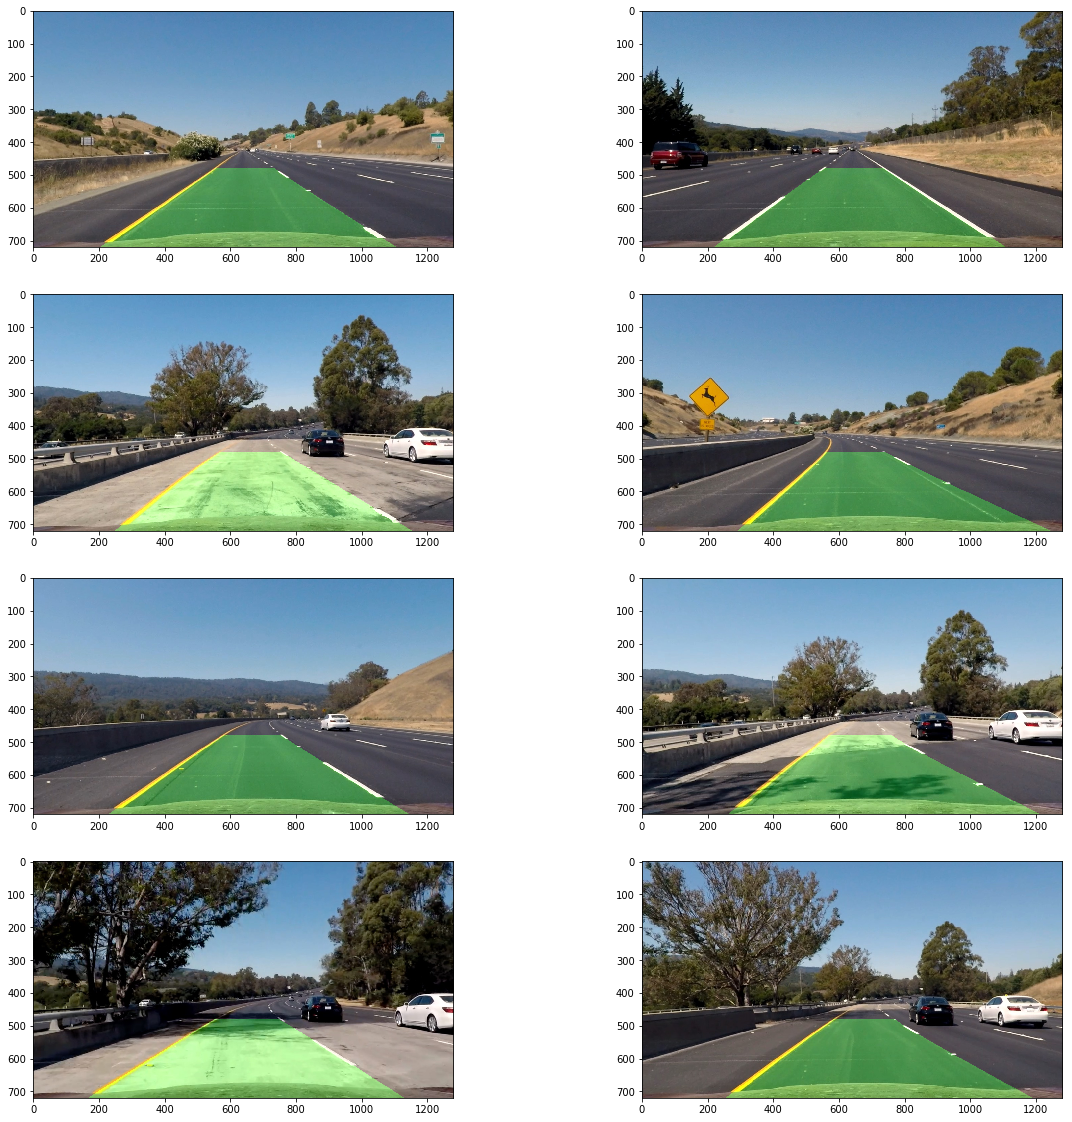

In [15]:
def draw_lines_region(undist_image, warped, left_fitx, right_fitx, ploty,source_points,destinaton_points):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    #Calcultaing unwarped matrix 
    Inv_Warped_matrix = cv2.getPerspectiveTransform(source_points,destinaton_points)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Inv_Warped_matrix, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    image_region_lines = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    return image_region_lines

fig = plt.figure(figsize=(20, 20))
count = 1
for file in list_images:
    fig.add_subplot(4, 2, count)
    image_full_region_lines = draw_lines_region(undistorted_images['undist_'+file], poly_fit_images['presp_binary_'+file][0], search_around_poly_out['presp_binary_'+file][1], search_around_poly_out['presp_binary_'+file][2], search_around_poly_out['presp_binary_'+file][3],dst,src)
    cool_image = image_full_region_lines
    plt.imshow(cool_image)
    count += 1

In [16]:
#7 CALIING ALL PREVIOUS FUNCTIONS#

False False
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing audio in project_videoTEMP_MPY_wvf_snd.mp3


100%|██████████| 111/111 [00:00<00:00, 146.17it/s]


[MoviePy] Done.
[MoviePy] Writing video output_images/project_video.mp4


  0%|          | 0/126 [00:00<?, ?it/s]

True True


  1%|          | 1/126 [00:00<01:33,  1.34it/s]

True True


  2%|▏         | 2/126 [00:00<01:09,  1.78it/s]

True True


  2%|▏         | 3/126 [00:01<00:53,  2.31it/s]

True True


  3%|▎         | 4/126 [00:01<00:41,  2.92it/s]

True True


  4%|▍         | 5/126 [00:01<00:33,  3.56it/s]

True True


  5%|▍         | 6/126 [00:01<00:28,  4.25it/s]

True True


  6%|▌         | 7/126 [00:01<00:24,  4.92it/s]

True True


  6%|▋         | 8/126 [00:01<00:21,  5.54it/s]

True True


  7%|▋         | 9/126 [00:01<00:19,  6.03it/s]

True True


  8%|▊         | 10/126 [00:01<00:18,  6.44it/s]

True True


  9%|▊         | 11/126 [00:02<00:17,  6.75it/s]

True True


 10%|▉         | 12/126 [00:02<00:16,  6.96it/s]

True True


 10%|█         | 13/126 [00:02<00:15,  7.19it/s]

True True


 11%|█         | 14/126 [00:02<00:15,  7.36it/s]

True True


 12%|█▏        | 15/126 [00:02<00:14,  7.47it/s]

True True


 13%|█▎        | 16/126 [00:02<00:14,  7.57it/s]

True True


 13%|█▎        | 17/126 [00:02<00:14,  7.64it/s]

True True


 14%|█▍        | 18/126 [00:02<00:14,  7.65it/s]

True True


 15%|█▌        | 19/126 [00:03<00:14,  7.64it/s]

True True


 16%|█▌        | 20/126 [00:03<00:13,  7.70it/s]

True True


 17%|█▋        | 21/126 [00:03<00:13,  7.76it/s]

True True


 17%|█▋        | 22/126 [00:03<00:13,  7.62it/s]

True True


 18%|█▊        | 23/126 [00:03<00:14,  7.32it/s]

True True


 19%|█▉        | 24/126 [00:03<00:14,  7.27it/s]

True True


 20%|█▉        | 25/126 [00:03<00:14,  7.12it/s]

True True


 21%|██        | 26/126 [00:04<00:14,  7.12it/s]

True True


 21%|██▏       | 27/126 [00:04<00:13,  7.12it/s]

True True


 22%|██▏       | 28/126 [00:04<00:13,  7.19it/s]

True True


 23%|██▎       | 29/126 [00:04<00:13,  7.17it/s]

True True


 24%|██▍       | 30/126 [00:04<00:13,  7.08it/s]

True True


 25%|██▍       | 31/126 [00:04<00:13,  7.09it/s]

True True


 25%|██▌       | 32/126 [00:04<00:13,  7.18it/s]

True True


 26%|██▌       | 33/126 [00:05<00:13,  7.12it/s]

True True


 27%|██▋       | 34/126 [00:05<00:12,  7.18it/s]

True True


 28%|██▊       | 35/126 [00:05<00:12,  7.09it/s]

True True


 29%|██▊       | 36/126 [00:05<00:12,  7.22it/s]

True True


 29%|██▉       | 37/126 [00:05<00:12,  7.37it/s]

True True


 30%|███       | 38/126 [00:05<00:11,  7.54it/s]

True True


 31%|███       | 39/126 [00:05<00:11,  7.60it/s]

True True


 32%|███▏      | 40/126 [00:05<00:11,  7.67it/s]

True True


 33%|███▎      | 41/126 [00:06<00:11,  7.72it/s]

True True


 33%|███▎      | 42/126 [00:06<00:10,  7.81it/s]

True True


 34%|███▍      | 43/126 [00:06<00:10,  7.70it/s]

True True


 35%|███▍      | 44/126 [00:06<00:10,  7.65it/s]

True True


 36%|███▌      | 45/126 [00:06<00:10,  7.66it/s]

True True


 37%|███▋      | 46/126 [00:06<00:10,  7.67it/s]

True True


 37%|███▋      | 47/126 [00:06<00:10,  7.72it/s]

True True


 38%|███▊      | 48/126 [00:07<00:10,  7.51it/s]

True True


 39%|███▉      | 49/126 [00:07<00:10,  7.41it/s]

True True


 40%|███▉      | 50/126 [00:07<00:10,  7.47it/s]

True True


 40%|████      | 51/126 [00:07<00:09,  7.52it/s]

True True


 41%|████▏     | 52/126 [00:07<00:09,  7.45it/s]

True True


 42%|████▏     | 53/126 [00:07<00:09,  7.45it/s]

True True


 43%|████▎     | 54/126 [00:07<00:09,  7.45it/s]

True True


 44%|████▎     | 55/126 [00:07<00:09,  7.45it/s]

True True


 44%|████▍     | 56/126 [00:08<00:09,  7.37it/s]

True True


 45%|████▌     | 57/126 [00:08<00:09,  7.41it/s]

True True


 46%|████▌     | 58/126 [00:08<00:09,  7.43it/s]

True True


 47%|████▋     | 59/126 [00:08<00:08,  7.46it/s]

True True


 48%|████▊     | 60/126 [00:08<00:08,  7.44it/s]

True True


 48%|████▊     | 61/126 [00:08<00:08,  7.49it/s]

True True


 49%|████▉     | 62/126 [00:08<00:08,  7.60it/s]

True True


 50%|█████     | 63/126 [00:09<00:08,  7.65it/s]

True True


 51%|█████     | 64/126 [00:09<00:08,  7.59it/s]

True True


 52%|█████▏    | 65/126 [00:09<00:08,  7.49it/s]

True True


 52%|█████▏    | 66/126 [00:09<00:08,  7.40it/s]

True True


 53%|█████▎    | 67/126 [00:09<00:07,  7.46it/s]

True True


 54%|█████▍    | 68/126 [00:09<00:07,  7.42it/s]

True True


 55%|█████▍    | 69/126 [00:09<00:07,  7.42it/s]

True True


 56%|█████▌    | 70/126 [00:09<00:07,  7.47it/s]

True True


 56%|█████▋    | 71/126 [00:10<00:07,  7.54it/s]

True True


 57%|█████▋    | 72/126 [00:10<00:07,  7.49it/s]

True True


 58%|█████▊    | 73/126 [00:10<00:07,  7.39it/s]

True True


 59%|█████▊    | 74/126 [00:10<00:07,  7.22it/s]

True True


 60%|█████▉    | 75/126 [00:10<00:06,  7.30it/s]

True True


 60%|██████    | 76/126 [00:10<00:06,  7.35it/s]

True True


 61%|██████    | 77/126 [00:10<00:06,  7.41it/s]

True True


 62%|██████▏   | 78/126 [00:11<00:06,  7.25it/s]

True True


 63%|██████▎   | 79/126 [00:11<00:06,  7.32it/s]

True True


 63%|██████▎   | 80/126 [00:11<00:06,  7.33it/s]

True True


 64%|██████▍   | 81/126 [00:11<00:06,  7.36it/s]

True True


 65%|██████▌   | 82/126 [00:11<00:05,  7.41it/s]

True True


 66%|██████▌   | 83/126 [00:11<00:05,  7.33it/s]

True True


 67%|██████▋   | 84/126 [00:11<00:06,  6.93it/s]

True True


 67%|██████▋   | 85/126 [00:12<00:05,  6.91it/s]

True True


 68%|██████▊   | 86/126 [00:12<00:05,  7.03it/s]

True True


 69%|██████▉   | 87/126 [00:12<00:05,  7.17it/s]

True True


 70%|██████▉   | 88/126 [00:12<00:05,  7.20it/s]

True True


 71%|███████   | 89/126 [00:12<00:05,  7.30it/s]

True True


 71%|███████▏  | 90/126 [00:12<00:04,  7.38it/s]

True True


 72%|███████▏  | 91/126 [00:12<00:04,  7.44it/s]

True True


 73%|███████▎  | 92/126 [00:12<00:04,  7.39it/s]

True True


 74%|███████▍  | 93/126 [00:13<00:04,  7.44it/s]

True True


 75%|███████▍  | 94/126 [00:13<00:04,  7.54it/s]

True True


 75%|███████▌  | 95/126 [00:13<00:04,  7.51it/s]

True True


 76%|███████▌  | 96/126 [00:13<00:04,  7.44it/s]

True True


 77%|███████▋  | 97/126 [00:13<00:04,  7.24it/s]

True True


 78%|███████▊  | 98/126 [00:13<00:03,  7.23it/s]

True True


 79%|███████▊  | 99/126 [00:13<00:03,  7.31it/s]

True True


 79%|███████▉  | 100/126 [00:14<00:03,  7.19it/s]

True True


 80%|████████  | 101/126 [00:14<00:03,  7.22it/s]

True True


 81%|████████  | 102/126 [00:14<00:03,  7.23it/s]

True True


 82%|████████▏ | 103/126 [00:14<00:04,  5.53it/s]

True True


 83%|████████▎ | 104/126 [00:14<00:04,  4.94it/s]

True True


 83%|████████▎ | 105/126 [00:15<00:04,  5.23it/s]

True True


 84%|████████▍ | 106/126 [00:15<00:04,  4.94it/s]

True True


 85%|████████▍ | 107/126 [00:15<00:03,  5.32it/s]

True True


 86%|████████▌ | 108/126 [00:15<00:03,  5.81it/s]

True True


 87%|████████▋ | 109/126 [00:15<00:03,  5.38it/s]

True True


 87%|████████▋ | 110/126 [00:16<00:03,  5.14it/s]

True True


 88%|████████▊ | 111/126 [00:16<00:02,  5.61it/s]

True True


 89%|████████▉ | 112/126 [00:16<00:02,  5.96it/s]

True True


 90%|████████▉ | 113/126 [00:16<00:02,  6.34it/s]

True True


 90%|█████████ | 114/126 [00:16<00:01,  6.68it/s]

True True


 91%|█████████▏| 115/126 [00:16<00:01,  6.93it/s]

True True


 92%|█████████▏| 116/126 [00:16<00:01,  7.08it/s]

True True


 93%|█████████▎| 117/126 [00:16<00:01,  7.22it/s]

True True


 94%|█████████▎| 118/126 [00:17<00:01,  7.27it/s]

True True


 94%|█████████▍| 119/126 [00:17<00:00,  7.36it/s]

True True


 95%|█████████▌| 120/126 [00:17<00:00,  7.40it/s]

True True


 96%|█████████▌| 121/126 [00:17<00:00,  7.44it/s]

True True


 97%|█████████▋| 122/126 [00:17<00:00,  7.42it/s]

True True


 98%|█████████▊| 123/126 [00:17<00:00,  7.36it/s]

True True


 98%|█████████▊| 124/126 [00:17<00:00,  7.22it/s]

True True


 99%|█████████▉| 125/126 [00:18<00:00,  7.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 



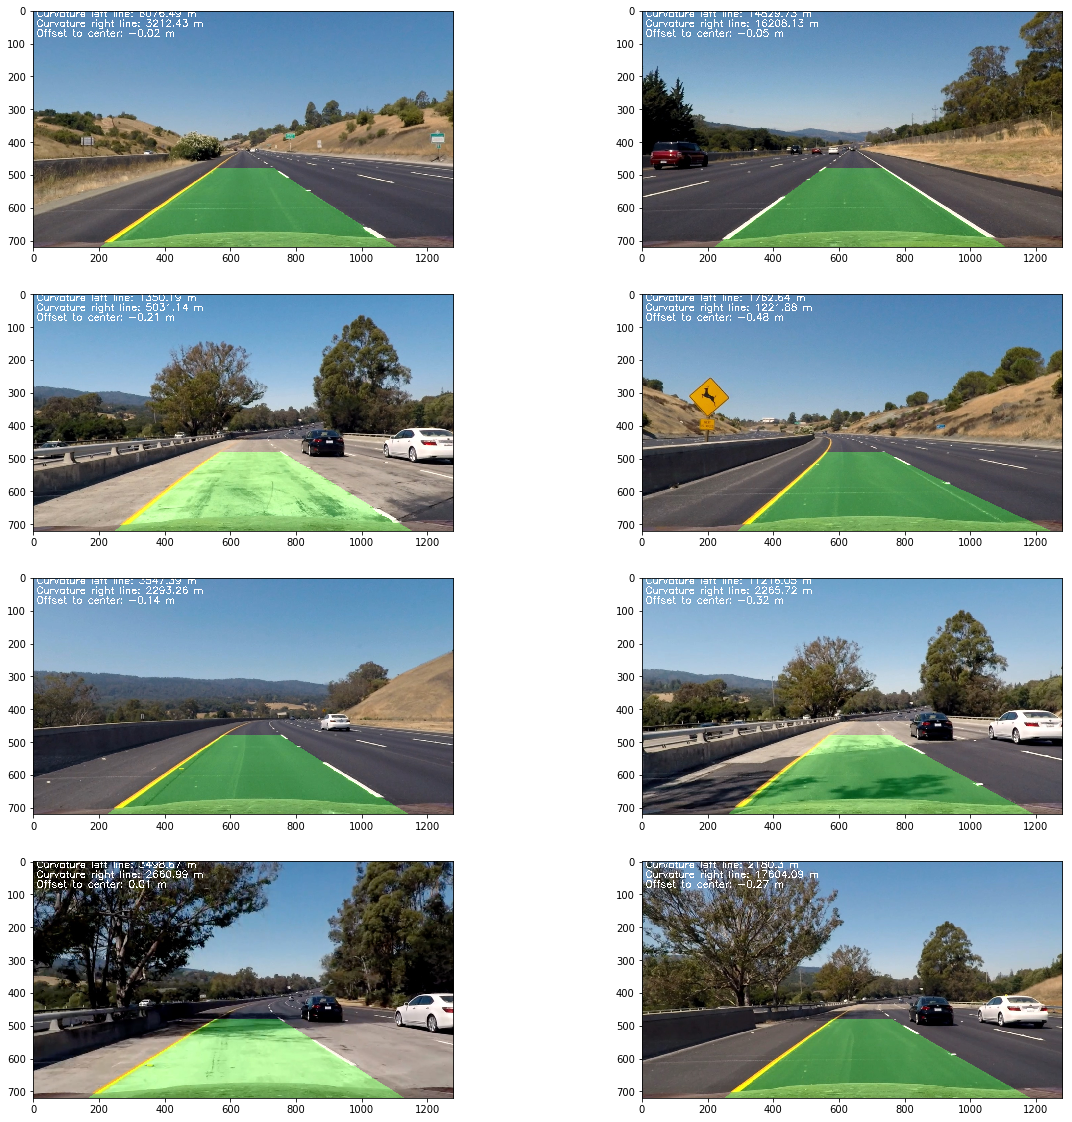

In [18]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        #distance in meters of vehicle center from the line
        self.line_base_pos = 0 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
def main_call(path_image):

    
    #Undistort the image and get binary image
    final_binary_image, undist_image  = get_binary_filtered_img(path_image, mtx, dist, saturation_thresh=(180, 255), sobel_thresh=(20, 80), light_thresh=(50,255))
    #generat 3d binary image just for testing
    final_binary_image_3d_format = np.dstack((final_binary_image, final_binary_image, final_binary_image))*255
    
    #Use perspective trasform for eagle view
    final_prespective_image = prespective_transform(final_binary_image,src,dst)
    
    
    if (left_line.detected == False  & right_line.detected == False) :
        print(left_line.detected, right_line.detected)
        #return polyfit for left and right line
        binary_warped, out_img, left_line.current_fit, right_line.current_fit, left_fitx, right_fitx, ploty = fit_polynomial(final_prespective_image)
        left_line.detected = right_line.detected = True
        print_test_image = out_img
    else:
        print(left_line.detected, right_line.detected)
        #draw line band base on polyfit
        result_image_band_line, left_fitx, right_fitx, ploty, left_curve_rad_m, right_curve_rad_m = search_around_poly(final_prespective_image, left_line.current_fit, right_line.current_fit)
        #left_line.detected = right_line.detected = False
        left_line.radius_of_curvature = left_curve_rad_m
        right_line.radius_of_curvature = right_curve_rad_m
        print_test_image = result_image_band_line
    
    #Compare the distance in three point bottom, middle and top in Y axis and decide if the they meet the treshholds
    
    #Check which line or line is not calculated correctly and choose the correct coeficient (Ax^2 + Bx + C) used in this loop to plot the image
    
    #If the coeficients are good store them and calculate the average, if not increment count of faluty and use stored average, if the counter is equal to 3 call fit_polynomial function to calculate squares
    
    #Calculate the offset to the center line
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_between_lines = ((right_fitx[len(right_fitx)-1]-left_fitx[len(left_fitx)-1])/2)+left_fitx[len(left_fitx)-1]
    Offset_center_lines = final_binary_image.shape[1]/2 - center_between_lines
    left_line.line_base_pos = right_line.line_base_pos = Offset_center_lines*xm_per_pix

    #draw region in green for undistorted image
    f_image_region_lines = draw_lines_region(undist_image, final_prespective_image, left_fitx, right_fitx, ploty,dst,src)
    
    
    #writing the lines curvature from each line as text in the image
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    leftLineTextPosition = (10,20)
    rightLineTextPosition = (10,50)
    offcetToCenterPosition = (10,80)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(f_image_region_lines,'Curvature left line: '+str(np.round(left_line.radius_of_curvature,2))+ ' m', 
    leftLineTextPosition, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    cv2.putText(f_image_region_lines,'Curvature right line: '+str(np.round(right_line.radius_of_curvature,2))+ ' m', 
    rightLineTextPosition, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    cv2.putText(f_image_region_lines,'Offset to center: '+str(np.round(left_line.line_base_pos,2))+ ' m', 
    offcetToCenterPosition, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    return f_image_region_lines #image_region_lines

left_line = Line()
right_line = Line()

fig = plt.figure(figsize=(20, 20))
count = 1
list_images = os.listdir("test_images/")
for file in list_images:
    path_image = "test_images/"+file
    main_call(path_image)
    print_image = main_call(path_image)
    fig.add_subplot(4, 2, count)
    plt.imshow(print_image)
    count += 1
    

input_video = "project_video.mp4"
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip(input_video).subclip(0,5)
#clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(main_call)
white_clip.write_videofile("output_images/"+input_video)